In [ ]:
# Import Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap


In [4]:
# Import full data, remove rows with NAs, normalize, create df EAL for 17 hazards only
cleaned_df = pd.read_pickle('cleaned_data.pkl')
cleaned_df = cleaned_df.dropna(axis=0)

columns_to_remove = ['STCOFIPS', 'lat', 'NAME','lon', 'STATEABBRV']
X_full = cleaned_df.drop(columns=columns_to_remove)

columns = X_full.columns
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

X_full_scaled_df = pd.DataFrame(X_full_scaled, columns=columns)
X_hazards = X_full_scaled_df.filter(like='_ALRB', axis=1)

k for 90% variance: 14


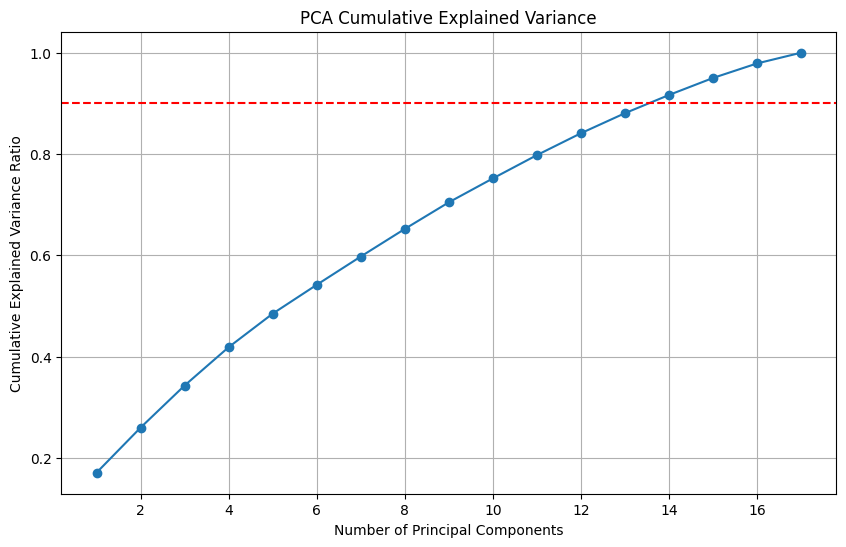

In [5]:
# PCA 
X_hazards = X_hazards.to_numpy()

pca = PCA()
X_pca = pca.fit_transform(scaler.fit_transform(X_hazards))

explained_variance = np.cumsum(pca.explained_variance_ratio_)
k_90 = np.argmax(explained_variance >= 0.9) + 1
print(f'k for 90% variance: {k_90}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("PCA Cumulative Explained Variance")
plt.grid()
plt.show()

k = np.argmax(explained_variance >= 0.9) + 1

Though choosing k=14 components explains 90% of the variance in X, the first component starts very low and doesn't explain much variance on its own. There is potentially an elbow around the 2nd or 3rd component but because it is not obvious and each component is so incremental, we will not use PCA to address collinearity in the features. 

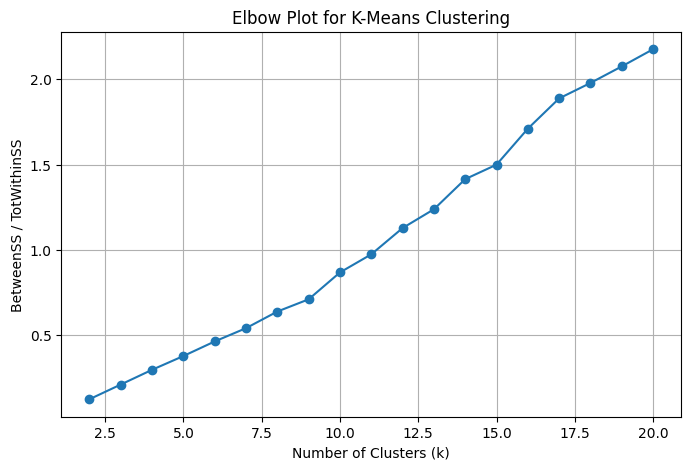

In [6]:
# K Means Elbow Plot
X_scaled = X_hazards
df_mat = X_scaled

n_obs = df_mat.shape[0]

if n_obs >= 2:
    ks = list(range(2, min(20, n_obs) + 1))
    ratios = []

    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=0)
        km.fit(df_mat)
        withinss = km.inertia_   
        totss = np.var(df_mat, axis=0).sum() * n_obs  
        betweenss = totss - withinss
        ratios.append((betweenss) / withinss)   

    plt.figure(figsize=(8, 5))
    plt.plot(ks, ratios, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('BetweenSS / TotWithinSS')
    plt.title('Elbow Plot for K-Means Clustering')
    plt.grid(True)
    plt.show()
else:
    print("Not enough complete counties to run elbow plot.")

There is a slight kink in the elbow plot at k=9 clusters, so we will start there for k-means clustering.

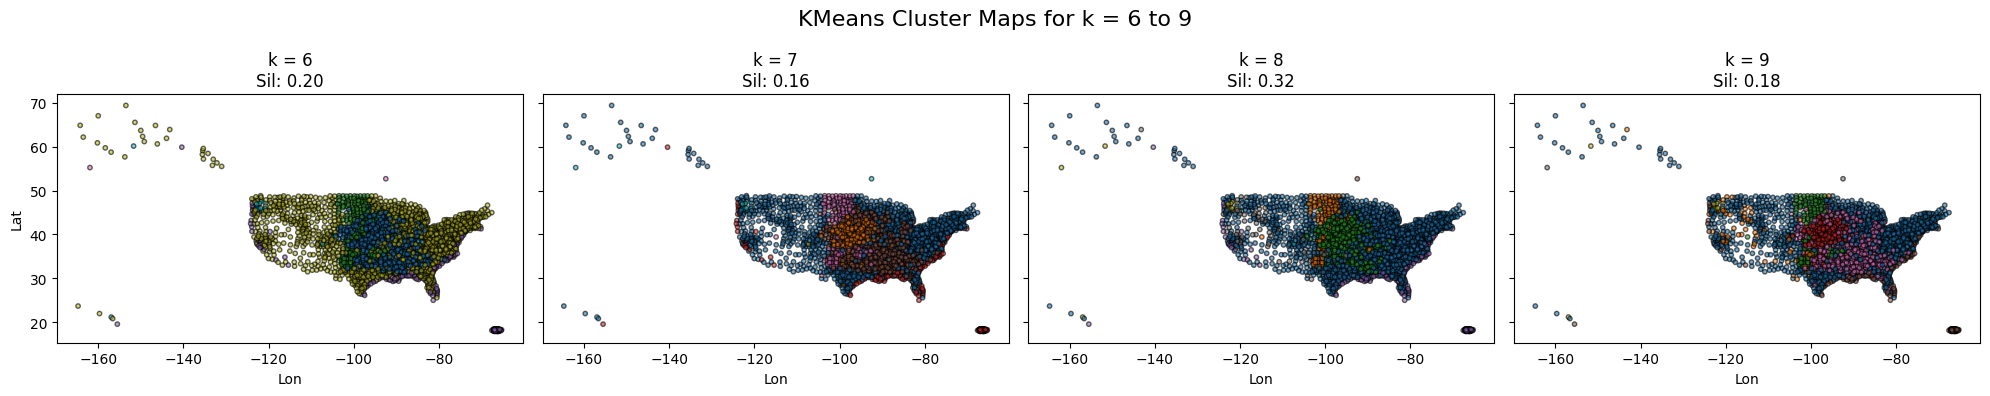

 k  silhouette_score
 6          0.200795
 7          0.155359
 8          0.316292
 9          0.176820


In [7]:
# K-Means Clustering for k=6-9
k_values = range(6, 10)
silhouette_scores = []
fig, axes = plt.subplots(1, len(k_values), figsize=(20, 4), sharex=True, sharey=True)

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
    cluster_assign = kmeans.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, cluster_assign)
    silhouette_scores.append({'k': k, 'silhouette_score': sil_score})

    temp_df = cleaned_df.copy()
    temp_df['cluster'] = cluster_assign
    colors = plt.cm.tab10(np.linspace(0, 1, k))
    cmap = ListedColormap(colors)

    axes[i].scatter(
        temp_df['lon'], temp_df['lat'],
        c=temp_df['cluster'], cmap=cmap,
        s=10, alpha=0.6, edgecolors='k'
    )
    axes[i].set_title(f'k = {k}\nSil: {sil_score:.2f}')
    axes[i].set_xlabel('Lon')
    if i == 0:
        axes[i].set_ylabel('Lat')

plt.suptitle("KMeans Cluster Maps for k = 6 to 9", fontsize=16)
plt.tight_layout()
plt.show()

score_df = pd.DataFrame(silhouette_scores)
print(score_df.to_string(index=False))

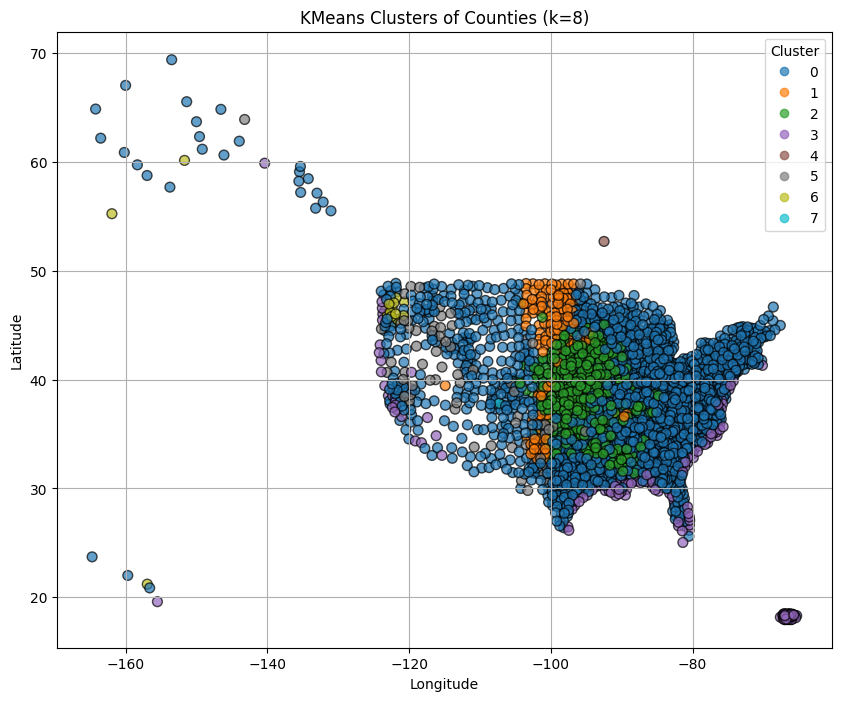

Silhouette Score: 0.316


In [8]:
# K means clustering with k=8 has highest silhouette score
k_opt = 8

kmeans = KMeans(n_clusters=k_opt, n_init=10, random_state=1)
cluster_assign = kmeans.fit_predict(X_scaled)

cleaned_df1 = cleaned_df.copy()  
cleaned_df1['cluster'] = cluster_assign

n_clusters = cleaned_df1['cluster'].nunique()
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))   
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    cleaned_df1['lon'], 
    cleaned_df1['lat'], 
    c=cleaned_df1['cluster'], 
    cmap=cmap,   
    s=50, 
    alpha=0.7, 
    edgecolors='k'
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clusters of Counties (k=8)")
plt.legend(*scatter.legend_elements(), title="Cluster", loc="best")
plt.grid(True)
plt.show()

sil_score = silhouette_score(X_scaled, cluster_assign)
print(f"Silhouette Score: {sil_score:.3f}")

The K-Means clustering (k=8) shows clear geographic clusters of counties based on the expected annual loss rate for buildings due to 17 different climate hazards. The purple on the coasts is likely correlated with coastal flooding, hurricanes, whereas the centrally-located green likely is a cluster of counties susceptible to tornadoes. 

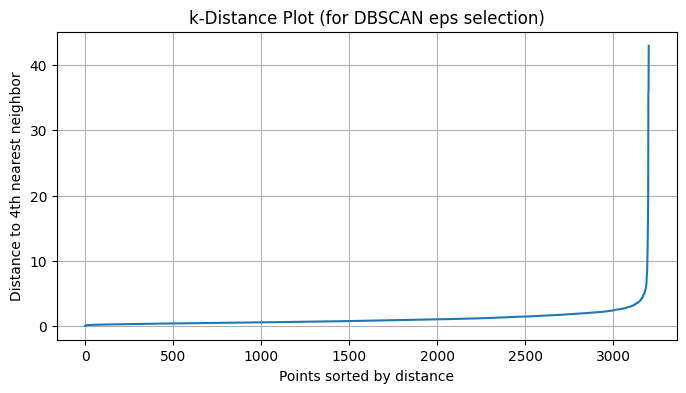

In [9]:
# K-distance plot to find eps for DBSCAN
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.xlabel("Points sorted by distance")
plt.title("k-Distance Plot (for DBSCAN eps selection)")
plt.grid(True)
plt.show()

Estimated number of clusters: 1
Estimated number of noise points: 9
Silhouette Coefficient: 0.852


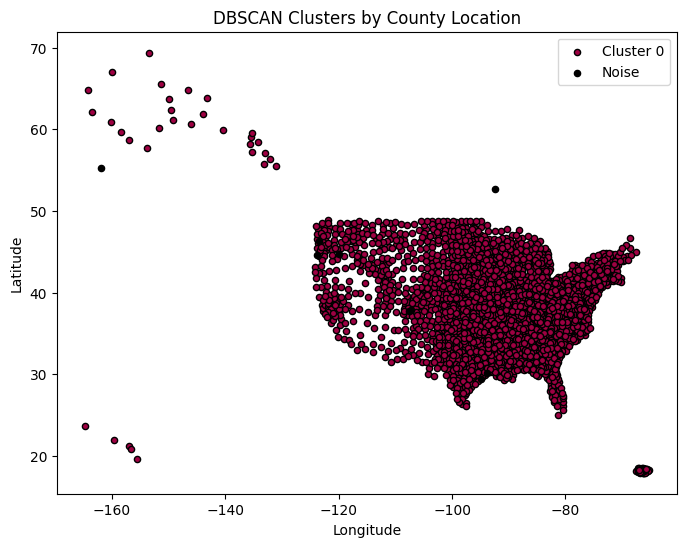

In [10]:
# DBSCAN Clustering with eps=7, min_pts=5
db = DBSCAN(eps=7, min_samples=5).fit(X_scaled)
labels = db.labels_

core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_scaled, labels))

cleaned_df["dbscan_cluster"] = np.nan
cleaned_df.loc[cleaned_df.index, "dbscan_cluster"] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise
    class_mask = (labels == k)
    plt.scatter(
        x=cleaned_df.loc[cleaned_df.index[class_mask], 'lon'],
        y=cleaned_df.loc[cleaned_df.index[class_mask], 'lat'],
        c=[tuple(col)],
        edgecolor='k',
        s=20,
        label=f"Cluster {k}" if k != -1 else "Noise"
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clusters by County Location")
plt.legend()
plt.show()

Even though the DBSCAN silhouette score is much higher (0.85) than K-Means (0.32), DBSCAN only provided 1 cluster, making the score inflated. On the other hand, K-Means provides full coverage by drawing complete usable clusters across all counties. 

        pct_units_pre1940 pct_overcrowded median_rent_pct_income pct_vacant_units pct_mobile_homes pct_lacking_plumbing median_year_built num_counties
                   median          median                 median           median           median               median            median             
cluster                                                                                                                                               
0                    9.78            1.80                  27.80            15.06             9.94                 3.17            1979.0         2160
1                   19.94            1.61                  23.40            19.20             6.78                 4.65            1967.5          156
2                   19.25            1.65                  25.40            16.26             6.68                 4.59            1972.0          585
3                    2.37            2.36                  30.15            19.21             

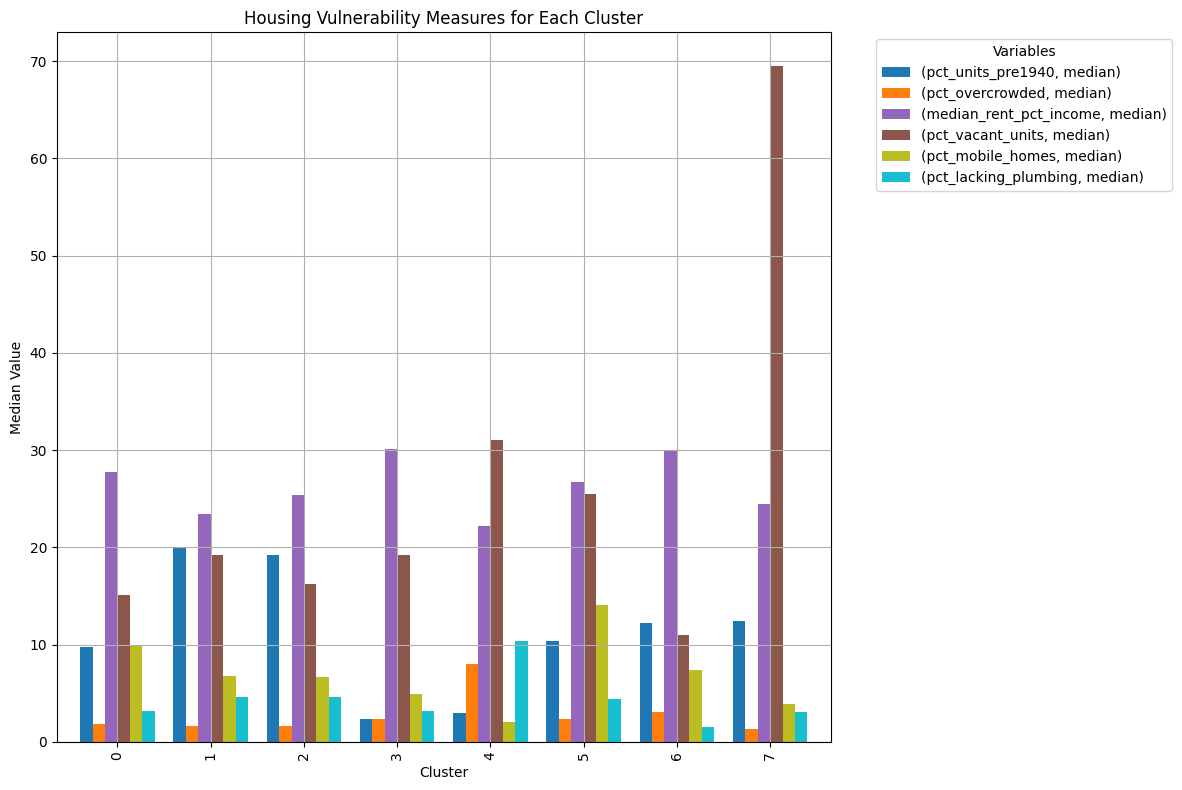

In [11]:
# Clusters' Summary Stats on Housing Vulnerability Features
cols = [
    'pct_units_pre1940',
    'pct_overcrowded',
    'median_rent_pct_income',
    'pct_vacant_units',
    'pct_mobile_homes',
    'pct_lacking_plumbing',
    'median_year_built'
]
summary_stats = cleaned_df1.groupby('cluster')[cols].agg(['median'])
cluster_counts = cleaned_df1['cluster'].value_counts()
summary_stats['num_counties'] = summary_stats.index.map(cluster_counts)

summary_df = pd.DataFrame(summary_stats.round(2))
print(summary_df.to_string(index=True, header=True))


summary_stats = summary_stats.drop(columns=['median_year_built', 'num_counties'])

fig, ax = plt.subplots(figsize=(12, 8))

summary_stats.plot(kind='bar', ax=ax, colormap=cmap, width=0.8)

ax.set_title('Housing Vulnerability Measures for Each Cluster')
ax.set_ylabel('Median Value')
ax.set_xlabel('Cluster')
ax.legend(title='Variables', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Two counties (4,7) are their own cluster -- Aleutians West Census Area, AK & Hinsdale County, CO
cluster_4_and_7 = cleaned_df1[cleaned_df1['cluster'].isin([4, 7])]
county_names = cluster_4_and_7['NAME']
print(county_names)
print(cluster_4_and_7.sort_values(by='cluster'))

1693             Hinsdale County, Colorado
2389    Aleutians West Census Area, Alaska
Name: NAME, dtype: object
     STCOFIPS        lat         lon STATEABBRV    BUILDVALUE          AREA  \
2389     2016  52.680224  -92.488109         AK  1.714899e+09  14258.993104   
1693     8053  37.821342 -107.300312         CO  4.687365e+08   1134.486271   

      AVLN_ALRB  CFLD_ALRB     CWAV_ALRB  ERQK_ALRB  ...  pct_overcrowded  \
2389   0.000000        0.0  0.000000e+00   0.001092  ...         7.968127   
1693   0.000003        0.0  9.103829e-14   0.000017  ...         1.357466   

      median_rent_pct_income  pct_renters_over_50pct_income  pct_vacant_units  \
2389                    22.2                       2.571429         31.043956   
1693                    24.5                       8.139535         69.496204   

      pct_renter_occupied  pct_mobile_homes  pct_lacking_plumbing  \
2389            69.721116          2.091633             10.370879   
1693            19.457014          3

I should have probably explained why these are 1-county clusters but I dont know...

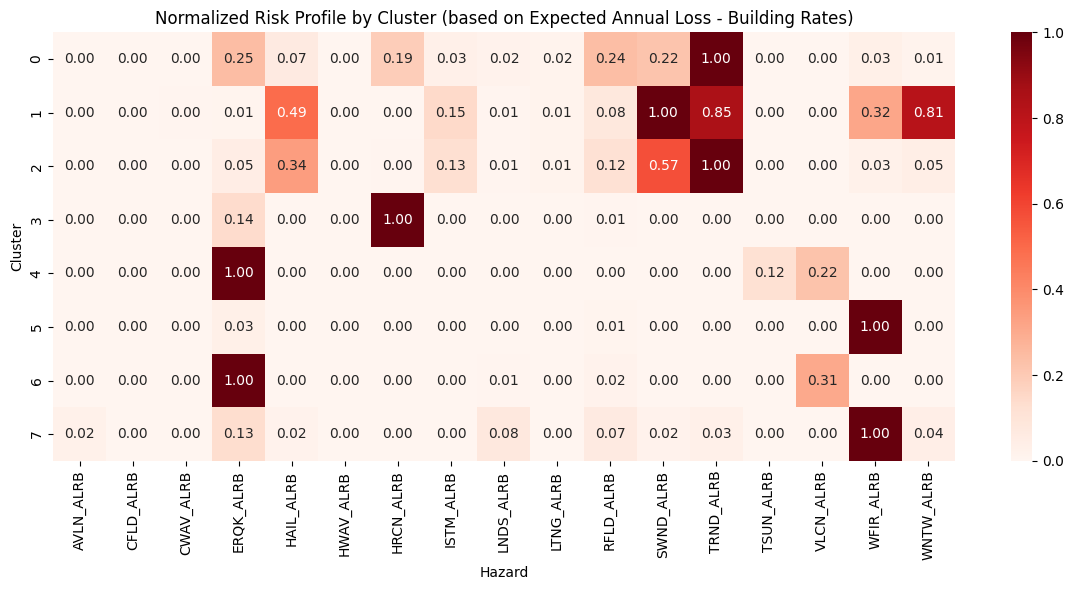

In [13]:
# Normalized Risk Profile by Cluster based on Expected Annual Loss - Building Rates for Hazards
alrb_cols = [col for col in cleaned_df1.columns if '_ALRB' in col]
risk_profile = cleaned_df1.groupby('cluster')[alrb_cols].median()
risk_profile_norm = risk_profile.div(risk_profile.max(axis=1), axis=0)
plt.figure(figsize=(12, 6))
sns.heatmap(risk_profile_norm, annot=True, cmap="Reds", fmt=".2f")
plt.title("Normalized Risk Profile by Cluster (based on Expected Annual Loss - Building Rates)")
plt.xlabel("Hazard")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

According to the risk profiles for each cluster, Cluster 0 seems like the most general that covers nearly the entire eastern half of the country and is marked by low expected building value loss for earthquake, hurricane, severe wind, river flooding, and highest EAL for tornadoes. Its housing vulnerability measures are the standard. Cluster 1 is marked by moderately high risk for building damage due to hail, tornado, wildfire, winter weather, and highest risk for severe wind. Most counties in this cluster are in the middle/north. Its housing vulnerability measures are the standard. It has the highest % of units built before 1940 and the lowest median age of units. Cluster 2 is marked by moderately high risk for hail and severe wind and highest risk for tornado. Most counties in this cluster are in the middle land locked center of the country. Its housing vulnerability measures are the standard. It also has nearly the highest % of units built before 1940. Cluster 3 has relatively no risk for anything except a low amount for earthquake and the highest for hurricanes, which makes sense because these counties are only located on the west and southeast coasts of the country. It has an especially low % of units built before 1940 and the highest median rent as a % of income of all the clusters. Cluster 5 has basically no risk for anything except the highest for wildfires, which make sense because these counties are located just interior to the west coast in states like Nevada. It has particularly high rates of vacant units and mobile homes. Cluster 6 has relatively moderate, but the highest of all clusters, expected annual loss risk for volcanic activity and the highest risk for earthquakes. Almost all of its counties are located in Washington state in the northwest but also includes scattered counties in Hawaii and Alaska.


                              NAME  cluster        lat         lon
1622  Riverside County, California        0  33.743677 -115.993833
1269      Mineral County, Colorado        0  37.668996 -106.924095
1348     Island County, Washington        0  48.162897 -122.575263
1354    Clallam County, Washington        0  48.110292 -123.934214
1376        Douglas County, Oregon        0  43.285346 -123.179557


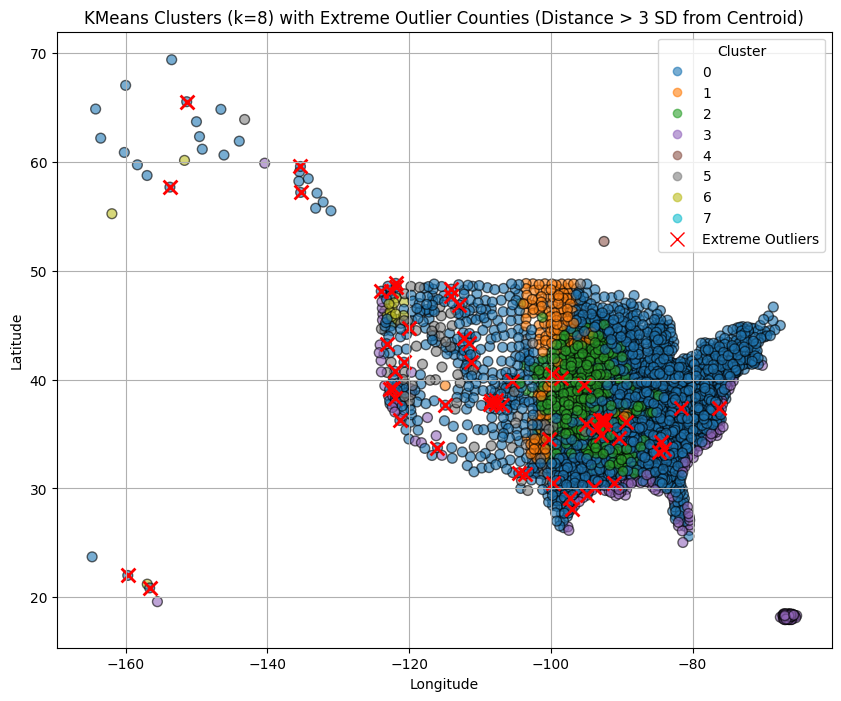

In [14]:
# Find counties that are extreme outliers in their clusters (> 3 SD above cluster's avg dist to centroid)
centroids = kmeans.cluster_centers_
cluster_assign = cleaned_df1['cluster'].values  # or however you store cluster labels

X_scaled_array = X_scaled.to_numpy() if hasattr(X_scaled, "to_numpy") else X_scaled
distances = np.linalg.norm(X_scaled_array - centroids[cluster_assign], axis=1)

cleaned_df1['dist_to_centroid'] = distances

outliers_by_cluster = []

for c in cleaned_df1['cluster'].unique():
    cluster_data = cleaned_df1[cleaned_df1['cluster'] == c]
    mean_dist = cluster_data['dist_to_centroid'].mean()
    std_dist = cluster_data['dist_to_centroid'].std()
    threshold = mean_dist + 3 * std_dist

    cluster_outliers = cluster_data[cluster_data['dist_to_centroid'] > threshold][['NAME', 'cluster', 'lat', 'lon']]
    outliers_by_cluster.append(cluster_outliers)

extreme_outliers_grouped = pd.concat(outliers_by_cluster).sort_values(by='cluster')
print(extreme_outliers_grouped.head(5))

extreme_outliers_grouped.to_pickle('outliers.pkl')

plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    cleaned_df1['lon'], 
    cleaned_df1['lat'], 
    c=cleaned_df1['cluster'], 
    cmap=cmap, 
    s=50, 
    alpha=0.6, 
    edgecolors='k'
)

plt.scatter(
    extreme_outliers_grouped['lon'], 
    extreme_outliers_grouped['lat'], 
    color='red', 
    marker='x', 
    s=100, 
    linewidths=2,
    label='Extreme Outliers'
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clusters (k=8) with Extreme Outlier Counties (Distance > 3 SD from Centroid)")

handles, labels = scatter.legend_elements()
handles.append(plt.Line2D([0], [0], marker='x', color='red', linestyle='', markersize=10, label='Extreme Outliers'))
labels.append('Extreme Outliers')
plt.legend(handles, labels, title="Cluster", loc="best")

plt.grid(True)
plt.show()

In [17]:
num_outlier_counties = extreme_outliers_grouped['NAME'].nunique()

print(f"Number of counties that are outliers for their respective cluster: {num_outlier_counties}")

Number of counties that are outliers for their respective cluster: 58


In [16]:
cleaned_df1.to_pickle('cleaned_data_2.pkl')